In [7]:
import time
from math import sqrt
import matplotlib.pyplot as plt
import random
import env_sim3
import env6
from liquid_net import LiquidNet
import os
import numpy as np
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from ncps.wirings import AutoNCP 
from ncps.torch import LTC
import seaborn as sns


In [8]:
class ExperienceDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        return tuple(map(lambda t: t[ind], self.data))

def create_shuffled_dataloader(data, batch_size, shuffle = True):
    ds = ExperienceDataset(data)
    return DataLoader(ds, batch_size = batch_size, shuffle = True)

In [9]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self,state_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_dims, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.liquid_net = LiquidNet(32)
        self.fc3 = torch.nn.Linear(32, n_actions)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)

        self.hidden_state = None

    def forward(self, x):
        # Initialize the hidden state if it is the first pass
        if self.hidden_state is None:
            self.hidden_state = torch.zeros(x.size(0), self.liquid_net.state_size).to(
                x.device
            )
        # Forward pass through the liquidnet
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x, self.hidden_state = self.liquid_net(x, self.hidden_state)
        x = self.fc3(x)
        policy = torch.nn.functional.softmax(x, dim=-1) 

        return policy
    
class ValueNetwork(torch.nn.Module):
    def __init__(self,state_dims):
        super(ValueNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(state_dims, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.liquid_net = LiquidNet(32)
        self.fc3 = torch.nn.Linear(32, 1)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)

        self.hidden_state = None

    def forward(self, x):
        # Initialize the hidden state if it is the first pass
        if self.hidden_state is None:
            self.hidden_state = torch.zeros(x.size(0), self.liquid_net.state_size).to(
                x.device
            )
        # Forward pass through the liquidnet
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x, self.hidden_state = self.liquid_net(x, self.hidden_state)
        value = self.fc3(x)
        return value

        
def weights_init(m):
    if isinstance(m,torch.nn.Linear):
        m.bias.data.fill_(0)
        torch.nn.init.kaiming_uniform_(m.weight)

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)

    
policy_model = PolicyNetwork(state_dims=6, n_actions = 6)
value_model = ValueNetwork(state_dims=6)

In [10]:
print(policy_model,value_model)
summary(policy_model, input_size=(1, 6))
summary(value_model, input_size=(1, 6))


PolicyNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (liquid_net): LiquidNet()
  (fc3): Linear(in_features=32, out_features=6, bias=True)
) ValueNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (liquid_net): LiquidNet()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             448
            Linear-2                [-1, 1, 32]           2,080
         LiquidNet-3       [[-1, 32], [-1, 32]]               0
            Linear-4                    [-1, 6]             198
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backwar

In [11]:
class PPO:
    def __init__(self, state_dim=6, action_dim=6, policy_lr=0.0005, value_lr=0.001, 
                 gamma=0.99, lam=0.95, beta_s=0.01,epsilon_clip=0.2, value_clip=0.4, 
                 epochs=5,batch_size=50,save_path='Models',env=None):
        
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)

        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=value_lr)

        self.gamma = gamma
        self.lamda = lam
        self.epsilon_clip = epsilon_clip
        self.value_clip = value_clip
        self.beta_s = beta_s
        self.epochs = epochs
        self.action_dim = action_dim
        self.batch_size = batch_size

        self.env = env
        self.env.run()

        self.save_path = save_path
        self.env_name = "auto-docking-iss"

        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        self.path = str(self.env_name)+'_PPO_'
        self.model_name = os.path.join(self.save_path, self.path)

        self.trajectory = {'states':[],'actions':[], 'rewards':[], 'action_logs':[],
                           'values':[],'done':[]}
        
        self.scores, self.episodes, self.average = [],[],[]
        self.value_loss_mean, self.policy_loss_mean = [], []

    def save(self,episode,score):
        torch.save({
            'actor': self.policy_net.state_dict(),
            'critic': self.value_net.state_dict()
        }, f'./'+ self.model_name + '_' + str(episode) + '_' + str(round(score,4)) + '.pt')

    def load(self,name):
        print(f'./{name}')
        try:
            data = torch.load(f'./{name}')
            self.policy_net.load_state_dict(data['actor'])
            self.value_net.load_state_dict(data['critic'])
        except Exception as e:
            print(e)

    # Función para visualizar la evolución del entrenamiento
    def plot_model(self, score, episode,num_episodes):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-10:]) / len(self.scores[-10:]))
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(1,figsize=(18, 9))
            plt.plot(self.episodes, self.scores, 'b')
            plt.plot(self.episodes, self.average, 'r')
            plt.ylabel('Score', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"scores.png")
            except OSError:
                pass

        return self.average[-1]
    
    def plot_loss(self,episode,num_episodes):        
        if (episode % 10 == 0 and episode > 0) or episode == num_episodes:#str(episode)[-2:] == "00":# much faster than episode % 100
            plt.figure(2,figsize=(18, 9))
            plt.plot(self.episodes, self.policy_loss_mean, 'b')
            plt.plot(self.episodes, self.value_loss_mean, 'r')
            plt.ylabel('Loss', fontsize=18)
            plt.xlabel('Steps', fontsize=18)
            try:
                plt.savefig(self.model_name+"loss.png")
            except OSError:
                pass
    

    #Almacenamiento de todas las variables que definen una transición para PPO
    def collect_trayectory(self,state,action,action_logs,reward,done,value):
        self.trajectory['states'].append(state)
        self.trajectory['actions'].append(action)
        self.trajectory['rewards'].append(reward)
        self.trajectory['values'].append(value)
        self.trajectory['action_logs'].append(action_logs)
        self.trajectory['done'].append(done)
    
    def clear_trayectory(self):
        for key in self.trajectory.keys():
            self.trajectory[key].clear()
    
    def generalized_advantage_estimation(self,next_state):
        advantages = np.zeros_like(self.trajectory['rewards'])
        last_gae_lambda = 0
        self.trajectory['values'].append(self.value_net(next_state.unsqueeze(0)).squeeze().detach())

        for t in reversed(range(len(self.trajectory['rewards']))):
            delta = self.trajectory['rewards'][t]+ self.gamma * self.trajectory['values'][t + 1].item() - self.trajectory['values'][t].item()
            advantages[t] = last_gae_lambda = delta + self.gamma * self.lamda * last_gae_lambda
        
        return np_to_tensor(advantages)


    def learn_from_episode_trajectory(self,next_state):
        self.policy_net.train()
        self.value_net.train()

        states = deepcopy(self.trajectory['states'])
        actions = deepcopy(self.trajectory['actions'])
        # rewards = deepcopy(self.trajectory['rewards'])
        values = deepcopy(self.trajectory['values'])
        action_logs = deepcopy(self.trajectory['action_logs'])
        # done = deepcopy(self.trajectory['done'])

        advantages = self.generalized_advantage_estimation(next_state).to(device)

        # prepare dataloader for policy phase training
        dl = create_shuffled_dataloader([states, actions, action_logs, advantages, values], self.batch_size,False)

        policy_loss_array = []
        value_loss_array = []

        for i in range(self.epochs):
            # self.policy_net.hidden_state = None
            # self.value_net.hidden_state = None

            for states, actions, action_log, advantages, values in dl:
                #Update policy_net
                new_action_probs = self.policy_net(states).squeeze()
                dist = torch.distributions.Categorical(new_action_probs)

                new_action_logs = dist.log_prob(actions)
                entropy = dist.entropy()

                # compute PPO-Clip
                ratios = torch.exp(new_action_logs - action_log)
                surr1 = ratios * advantages
                surr2 = ratios.clamp(1 - self.epsilon_clip, 1 + self.epsilon_clip) * advantages
                policy_loss = -torch.mean(torch.min(surr1, surr2) - self.beta_s * entropy)
                policy_loss_array.append(policy_loss.detach().numpy())

                self.policy_optimizer.zero_grad() # Clean gradients
                policy_loss.mean().backward() # Compute gradients
                self.policy_optimizer.step() #Update weights

                #Update value_net
                new_values = self.value_net(states).squeeze()
                value_clipped = values + (new_values - values).clamp(-self.value_clip, self.value_clip)
                value_loss_1 = (value_clipped.flatten() - advantages) ** 2
                value_loss_2 = (values.flatten() - advantages) ** 2
                value_loss = torch.mean(torch.max(value_loss_1, value_loss_2))
                value_loss_array.append(value_loss.detach().numpy())

                self.value_optimizer.zero_grad() # Clean gradients
                value_loss.backward() # Compute gradients 
                self.value_optimizer.step() #Update weights

                self.policy_net.hidden_state = self.policy_net.hidden_state.detach()
                self.value_net.hidden_state = self.value_net.hidden_state.detach()
            
        self.value_loss_mean.append(sum(value_loss_array)/self.epochs)
        self.policy_loss_mean.append(sum(policy_loss_array)/self.epochs)

        # print(f"\n Mean Policy loss: {self.value_loss_mean[-1]:.4f}. Mean Value loss: {self.policy_loss_mean[-1]:.4f}")
        
        self.policy_net.eval()
        self.value_net.eval()


    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        state = self.env.reset()
        return np_to_tensor(self.process_state(state))
    
     # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done = self.env.step(action)
        next_state = self.process_state(next_state)
        return np_to_tensor(next_state), reward, done

    def process_state(self,state):
        state_processed = np.array(state)
        state_processed[0] = state_processed[0] / 30 # Position array
        state_processed[1] = state_processed[1] / 3 # Position array
        state_processed[2] = state_processed[2] / 3 # Position array
        return state_processed
    
    def train(self,init_episode=1,num_episodes=200,max_steps=200,dt=0.01):
        average = 0
        self.policy_net.eval()
        self.value_net.eval()

        max_score_average = -5000

        num_episodes += init_episode

        for episode in range(init_episode,num_episodes):
            self.clear_trayectory()

            state = self.reset()
            score = 0

            SAVING = ""
            self.policy_net.hidden_state = None
            self.value_net.hidden_state = None

            for step in range(1,max_steps+1):
                action_probs = self.policy_net(state.unsqueeze(0)).squeeze().detach()
                dist = torch.distributions.Categorical(action_probs)
                action = dist.sample()
                action_log = dist.log_prob(action)
                # print(action,action_probs,action_log)

                value = self.value_net(state.unsqueeze(0)).squeeze().detach()
                
                next_state,reward,done = self.step(action.item())    
                self.collect_trayectory(state,action,action_log,reward,done,value)

                state = next_state

                score += reward

                # print(state)
                # print(f'\rSteps: {step}/{max_steps}. Action: {action}. Reward/Value: {round(reward,2)}/{round(value.item(),4)}. Done: {done}        ', end='', flush=True)

                if done:
                    break
                
                # time.sleep(dt)

            self.learn_from_episode_trajectory(next_state)
            self.clear_trayectory()

            average = self.plot_model(score, episode,num_episodes)
            self.plot_loss(episode,num_episodes)
            
            if episode > 200 and average >= max_score_average:
                max_score_average = average
                self.save(episode,average)
                SAVING = "SAVING"
            # elif episode % 10 == 0:
            #     self.save(episode,average)
            #     SAVING = "SAVING"
            else:
                SAVING = ""
            
            print(f"\rEpisode: {episode}/{num_episodes-1}, score/average: {score:.4f}/{average:.4f} {SAVING}           ", end='', flush=True)


        # close environemnt when finish training
        self.save(episode,average)

    def test(self,max_steps,dt=0.01):
        self.policy_net.eval()
        self.value_net.eval()

        self.clear_trayectory()
        state = self.reset()
        score = 0

        self.policy_net.hidden_state = None
        self.value_net.hidden_state = None

        for step in range(1,max_steps+1):
            action_probabilities = self.policy_net(state.unsqueeze(0))
            action = torch.argmax(action_probabilities, dim=-1).item()#np.argmax(self.policy_net(state).squeeze().detach().numpy())
            value = self.value_net(state.unsqueeze(0)).squeeze().detach()
            
            next_state,reward,done = self.step(action)    

            state = next_state

            score += reward

            print(f'\rSteps: {step}/{max_steps}. Action: {action}. Score/Value: {round(score,2)}/{round(value.item(),4)}. Done: {done}', end='', flush=True)

            if self.env.done or step > max_steps:
                break
                
            time.sleep(dt)
        
        print(f'\nNext state: {state}')


In [12]:
dt = 0.5
env = env_sim3.Env(dt=dt)
agent = PPO(save_path='Models15',env=env,batch_size=500)

Episode: 32/1000, score/average: -150.0080/-262.1940            

KeyboardInterrupt: 

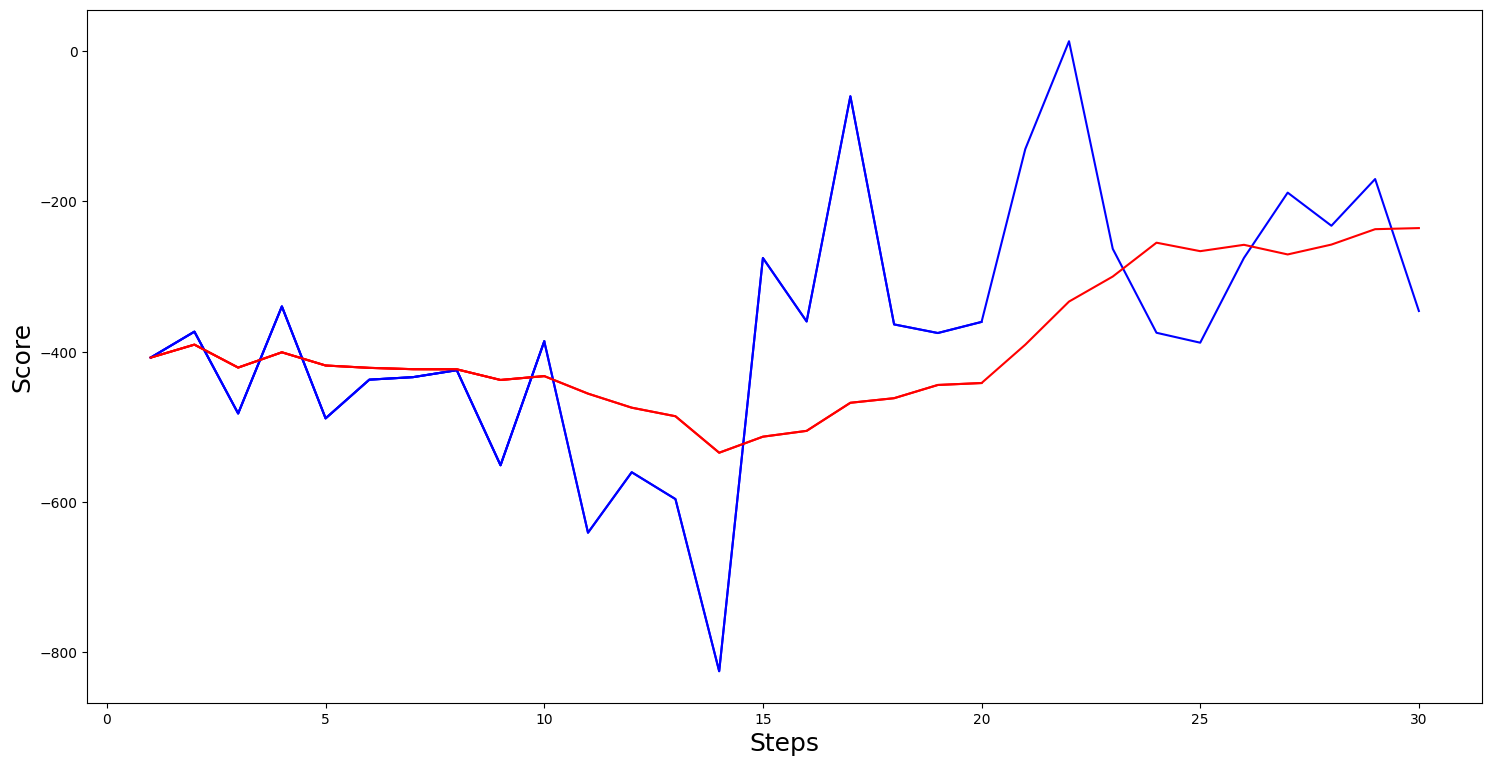

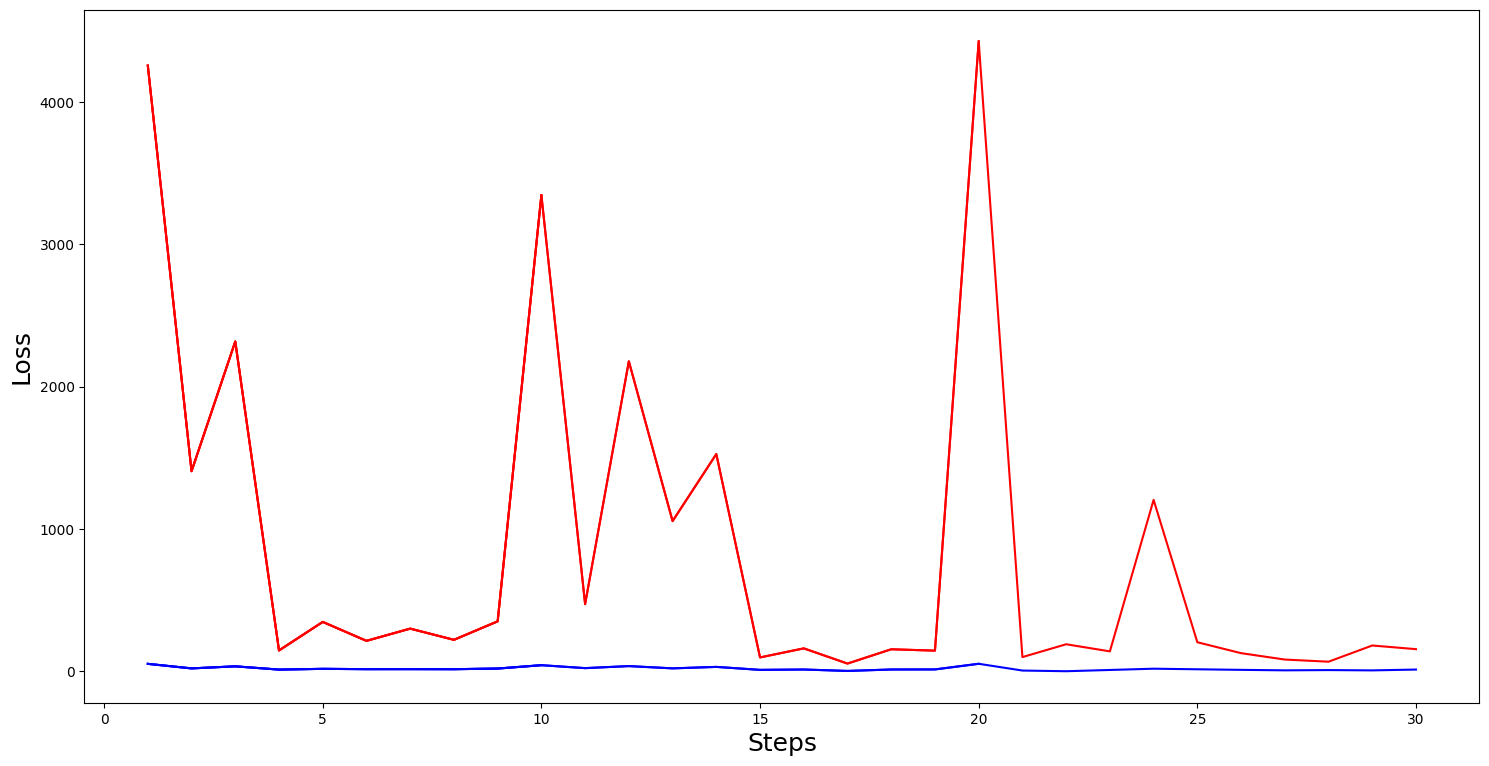

In [13]:
max_steps = 250
agent.train(init_episode=1,num_episodes=1000,max_steps=int(max_steps/dt))

In [ ]:
agent.load("Models13/auto-docking-iss_PPO__1212_548.8147.pt")

In [ ]:
agent.test(1000)

In [ ]:
env2 = env6.Env(port=5555)
agent2 = PPO(env=env2)

In [ ]:
agent2.load("Models13/auto-docking-iss_PPO__1212_548.8147.pt")

In [ ]:
agent2.test(max_steps=500,dt=0.5)